#### Calculate mutual information

In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas
from scipy.linalg import det
from shapely.geometry import Point, Polygon
import pandas as pd
import math
import json
from scipy.spatial import Delaunay
from generate_sample_U import *
import dill as pickle


In [9]:
def load_model(filename):
    path = f"../gp-models/GPR-models/ST-SVGP/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, scalers

In [19]:
# incrementally grab the sensors in the order that they are placed
# (calculate MI for 1st sensor, then for 1st & 2nd sensor, etc.)
# initialize list for MI storage
def GPR_mutual_info(GPR, k, A_df, U_df, t):
    MI = np.array([],dtype=float)

    for i in range(k):
        print(i)
        A_df["t"] = t
        A = A_df[["t", "scaled_latitude", "scaled_longitude"]].values
        U_df["t"] = t
        U = U_df[["t", "scaled_latitude", "scaled_longitude"]].values
        
        n = np.arange(0,i+1)
        ## grab first n sensors placed
        test_X = A[n,:].reshape(i+1, A.shape[1])        
        
        ## add in U
        test_XU = np.append(test_X, U, axis=0)

        ## compute covariance matrix
        if not isinstance(test_XU, np.ndarray):
            test_XU = np.array(test_XU).reshape(-1,1)
        cov_mat_XU = GPR.predict(test_XU, return_cov=True)[1]

        print(cov_mat_XU)
        print(cov_mat_XU.shape)
        
        XX_cov = cov_mat_XU[:i+1,:i+1]
        #print(XX_cov.shape)
        UU_cov = cov_mat_XU[i+1:cov_mat_XU.shape[0], i+1:cov_mat_XU.shape[0]]
        #print(UU_cov.shape)
        
        ## calculate 
        det_XU = det(cov_mat_XU)
        det_XX = det(XX_cov)
        det_UU = det(UU_cov)

        print("det_XU = " + str(det_XU))
        print("log(det_XU) = " + str(np.log(det_XU)))
        print("det_XX = " + str(det_XX))
        print("log(det_XX) = " + str(np.log(det_XX)))
        print("det_UU = " + str(det_UU))
        print("log(det_UU) = " + str(np.log(det_UU)))
        if det_XU == 0:
            print("skipping " + str(i))
        else:
            mi_star = 0.5*np.log((det_XX * det_UU) / (det_XU))
            alt_mi_star = 0.5*(np.log(det_XX) + np.log(det_UU) - np.log (det_XU))
            print("mi = " + str(mi_star))
            print("alternative mi = " + str(alt_mi_star))
            MI = np.append(MI, mi_star)

    return MI

In [20]:
def STVGP_mutual_info(GP, k, A_df, U_df, t):
    '''
    GP : ST-VGP model
    k : int : number of sensors to be placed
    A_df : pd.DataFrame : sensor sites of optimal mutual information; columns = ["t", "latitude", "longitude", "scaled_latitude", "scaled_longitude"]
    U_df : pd.DataFrame : locations where sensors cannot be placed
    t : int : time index
    '''
    MI = np.array([],dtype=float)

    for i in range(k):
        print(i)
        A_df["t"] = t
        A = A_df[["scaled_latitude", "scaled_longitude"]].values
        U_df["t"] = t
        U = U_df[["scaled_latitude", "scaled_longitude"]].values

        
        ## grab first n sensors placed
        n = np.arange(0,i+1)
        test_X = A[n,:].reshape(i+1, A.shape[1])

        ## add in U
        yA_R = np.append(test_X, U, axis=0)

        yA_t = np.array([[t]])
        yA_R = np.tile(yA_R, [yA_t.shape[0], 1, 1])
        yA_mean, cov_mat_XU = GP.cov(X=yA_t, R=yA_R)

        print(cov_mat_XU)
        print(cov_mat_XU.shape)
        
        XX_cov = cov_mat_XU[:i+1,:i+1]
        #print(XX_cov.shape)
        UU_cov = cov_mat_XU[i+1:cov_mat_XU.shape[0], i+1:cov_mat_XU.shape[0]]
        #print(UU_cov.shape)
        
        ## calculate 
        det_XU = det(cov_mat_XU)
        det_XX = det(XX_cov)
        det_UU = det(UU_cov)

        print("det_XU = " + str(det_XU))
        print("log(det_XU) = " + str(np.log(det_XU)))
        print("det_XX = " + str(det_XX))
        print("log(det_XX) = " + str(np.log(det_XX)))
        print("det_UU = " + str(det_UU))
        print("log(det_UU) = " + str(np.log(det_UU)))
        if det_XU == 0:
            print("skipping " + str(i))
        else:
            mi_star = 0.5*np.log((det_XX * det_UU) / (det_XU))
            alt_mi_star = 0.5*(np.log(det_XX) + np.log(det_UU) - np.log (det_XU))
            print("mi = " + str(mi_star))
            print("alternative mi = " + str(alt_mi_star))
            MI = np.append(MI, mi_star)
            
    return MI

In [ ]:
model_name = 'STSVGP_MODEL_2936'
model, df, train_df, test_df, scalers = load_model(model_name)

# path = f"../gp-models/GPR-models/ST-SVGP/{model_name}/{model_name}"
# model = pickle.load(open(f"{path}_model.sav", 'rb'))
# scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))

In [21]:
A_df = pickle.load(open(f'../optimization/krause-output/{model_name}_mutual_info_df.sav', 'rb'))
# scale coordinates
k = A_df.shape[0]
for feature in scalers:
    A_df[f"scaled_{feature}"] = scalers[feature].transform(A_df[[feature]].values)+0.00001*np.random.rand(k, 1)
A_df

,site,site_score,order,latitude,longitude,scaled_latitude,scaled_longitude
0,CT1,3.361238,1,51.511491,-0.095807,0.133587,0.225948
1,WA9,2.877045,2,51.465033,-0.215825,-0.678381,-0.517979
2,BL0,1.845265,3,51.522287,-0.125848,0.322271,0.039738
3,RI2,1.805667,4,51.476168,-0.230427,-0.483758,-0.608496
4,LW2,1.756465,5,51.474954,-0.039641,-0.504974,0.574085
5,KC4,1.669056,6,51.487437,-0.168397,-0.286809,-0.224003
6,GN0,1.639080,7,51.490532,0.074003,-0.232717,1.278497
7,GR5,1.482538,8,51.483449,-0.000146,-0.356507,0.818894
8,WM4,1.457025,9,51.510205,-0.128177,0.111111,0.025296
9,HI0,1.420857,10,51.496309,-0.460826,-0.131751,-2.036610


In [18]:
S_df, U_df = generate_placement_sets(df, scalers, n=1000, plot=True)

In [23]:
t = 0

In [ ]:
MI = STVGP_mutual_info(model, k, A_df, U_df, t)
MI

/var/folders/8s/cmks6vfx4vxb_x2clcgwn8080000gn/T/ipykernel_52632/667043878.py:4: RuntimeWarning: divide by zero encountered in log
  MI_placeholder = [np.log(i) for i in range(k)]


Text(0.5, 0, 'Number of Sensors')

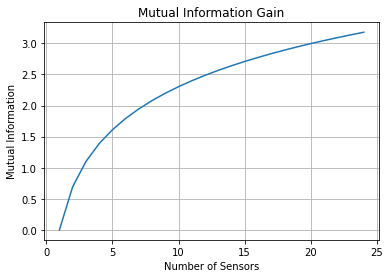

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# MI_placeholder = [np.log(i) for i in range(k)]
# plt.plot(list(range(k)), MI_placeholder)

plt.plot(list(range(k)), MI)
plt.grid()
plt.title('Mutual Information Gain')
plt.ylabel('Mutual Information')
plt.xlabel('Number of Sensors')